In [2]:
from tensorflow.keras.applications import MobileNet

model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [1]:
!git clone https://github.com/ari-dasci/OD-WeaponDetection.git


Cloning into 'OD-WeaponDetection'...
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10232/10232), done.
remote: Total 50755 (delta 11), reused 11673 (delta 11), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 30.20 MiB/s, done.
Resolving deltas: 100% (10978/10978), done.
Updating files: 100% (63128/63128), done.


In [4]:
%cd /content
%mkdir dataset
%cd dataset
%mkdir knife
%mkdir handheld
%mkdir guns
%cp -r "/content/OD-WeaponDetection/Knife_detection/Images/." knife
%cp -r "/content/OD-WeaponDetection/Pistol detection/Weapons/." guns
%cp -r "/content/OD-WeaponDetection/Weapons and similar handled objects/Sohas_weapon-Detection/images/." handheld


/content
mkdir: cannot create directory ‘dataset’: File exists
/content/dataset
mkdir: cannot create directory ‘knife’: File exists
mkdir: cannot create directory ‘guns’: File exists


In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the directory containing your dataset
dataset_dir = '/content/dataset'

# Get the list of subdirectories (classes) in the dataset directory
classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name)) and class_name != ".git"]

# Define the dimensions for resizing the images
img_height, img_width = 224, 224

# Define batch size for training and validation
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=classes
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=classes
)

# Print the number of classes and their labels
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

class_labels = train_generator.class_indices
print("Class labels:", class_labels)


Found 8569 images belonging to 3 classes.
Found 1511 images belonging to 3 classes.
Number of classes: 3
Class labels: {'knife': 0, 'guns': 1, 'handheld': 2}


In [6]:
import tensorflow as tf

# Define the CNN architecture
def create_cnn():
    # Load pre-trained model with ImageNet weights (e.g., MobileNetV2)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                    include_top=False,
                                                    weights='imagenet')

    # Freeze the pre-trained layers

    for layer in base_model.layers[:-3]:
      layer.trainable = False



    # Add custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
      #  tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.Dense(8, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')  # Change num_classes to your number of output classes
    ])

    return model

# Create the CNN
cnn_model = create_cnn()

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display model summary
#cnn_model.summary()


9406464/9406464 [==============================] - 0s 0us/step


In [7]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 3

In [8]:
from tensorflow.keras.applications import MobileNet  # Import MobileNet
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the MobileNet model pretrained on ImageNet without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the trained model
model.save('weapon_detection_model_mobilenet.h5')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

48/48 [==============================] - 34s 700ms/step - loss: 4.5984 - accuracy: 0.4785
Validation Accuracy: 47.85%
Validation Loss: 4.5984


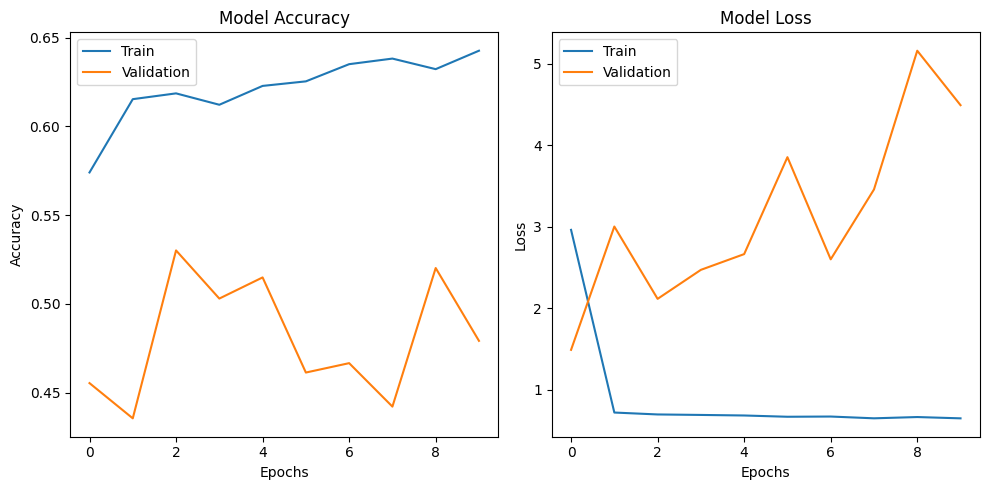

In [10]:
# Visualize Training History
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Make Predictions
import numpy as np

# Load the saved model
loaded_model = tf.keras.models.load_model('weapon_detection_model_mobilenet.h5')

# Make predictions on the validation data
predictions = loaded_model.predict(validation_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the validation data generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculate the accuracy on the validation data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy on Validation Data: {accuracy * 100:.2f}%")

48/48 [==============================] - 41s 846ms/step
Accuracy on Validation Data: 34.81%


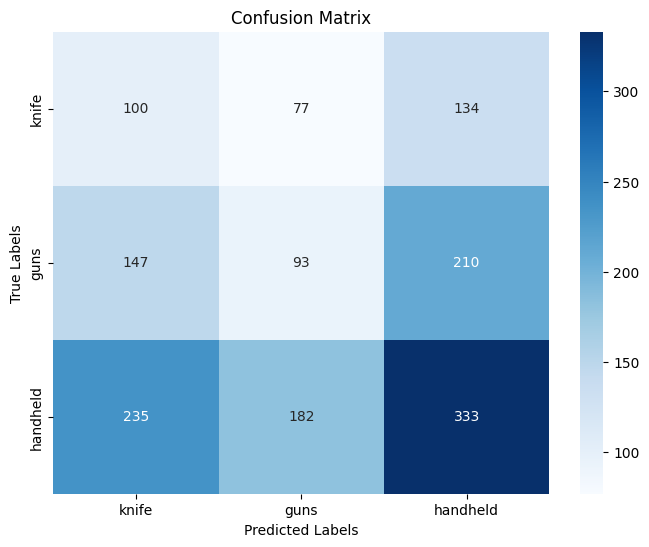

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Generate a classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       knife       0.21      0.32      0.25       311
        guns       0.26      0.21      0.23       450
    handheld       0.49      0.44      0.47       750

    accuracy                           0.35      1511
   macro avg       0.32      0.32      0.32      1511
weighted avg       0.37      0.35      0.35      1511



In [14]:
import pandas as pd

# Create a DataFrame to store true and predicted labels
results_df = pd.DataFrame({
    'True_Labels': true_classes,
    'Predicted_Labels': predicted_classes,
    'Image_Filenames': validation_generator.filenames
})

# Save the DataFrame to a CSV file
results_df.to_csv('predictions.csv', index=False)

Saving ABbframe00154.jpg to ABbframe00154.jpg


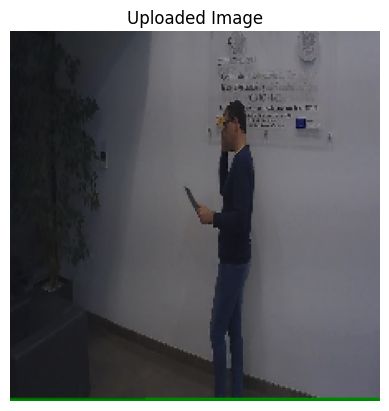

1/1 [==============================] - 1s 910ms/step
Predicted Class: handheld - 94.41%
Remaining Classes:
knife: 5.30%
guns: 0.29%


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Upload an image file
from google.colab import files
uploaded = files.upload()

# Get the uploaded image file name
file_name = list(uploaded.keys())[0]

# Load the uploaded image
img_path = file_name
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.title('Uploaded Image')
plt.show()

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to create a batch of 1 image
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the input image using MobileNet's preprocessing function
input_img = tf.keras.applications.mobilenet.preprocess_input(img_array)

# Make predictions
predictions_single = loaded_model.predict(input_img)

# Map predicted probabilities to class labels
class_labels = {0: 'knife', 1: 'guns', 2: 'handheld'}  # Assuming your class labels

# Get the predicted class label
predicted_class_single = np.argmax(predictions_single, axis=1)[0]
predicted_label = class_labels[predicted_class_single]

# Calculate the percentage of predicted object
predicted_percentage = predictions_single[0][predicted_class_single] * 100

# Create a dictionary to store percentages for each class
percentage_dict = {}

for i, prob in enumerate(predictions_single[0]):
    percentage_dict[class_labels[i]] = prob * 100

# Remove the predicted class percentage from the dictionary
percentage_dict.pop(predicted_label)

# Display the predicted class and its percentage
print(f"Predicted Class: {predicted_label} - {predicted_percentage:.2f}%")

# Display the remaining classes and their percentages
print("Remaining Classes:")
for label, percentage in percentage_dict.items():
    print(f"{label}: {percentage:.2f}%")


